<br>
<h1 style="font-family:lato; font-size:300%; text-align:center;"> 
    <span style='color:#00acee'> Twitter analysis of </span>
    <span class="hr3" style='color:#e40843'>Canada</span>
</h1>

***

Something something...

## Imports

In [1]:
# !pip install GetOldTweets3 #If you need to install this package, uncomment this line and run it
import GetOldTweets3 as got 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re 
from datetime import timedelta
import datetime, time
import pytz

# WordCloud:
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Necessary to plot timeseries:
pd.plotting.register_matplotlib_converters()

The **GetOldTweets3** package is really nice because it allows you to look for very old tweets (as opposed to the free version of the API from twitter). However, the downside is that it has less functionality.

Nonetheless, as we shall see, this package provides enough functionality to make a nice analysis about a specific topic.

GOT3 allows some criteria one can make use of to search on the Twit-sphere 
<img src='https://miro.medium.com/max/576/1*xVu-oaDRWW4yWF7yZ8W4Xw.png'>

## Creating a dataframe from tweets

We have a list of twitter objects and would like now to create lists which will enable us to put a dataframe together. 

We will define a function that translates a list of tweet objects into a friendly, understandable pandas dataframe

In [2]:
%%time
def TweetDataframe(tweets):
    text = []
    usr = []
    rt=[]
    fav=[]
    ht=[]
    mentions=[]
    id_ = []
    date=[]
    geo=[]
    for i in range(len(tweets)):
    #     print('{} \n '.format(got.manager.TweetManager.getTweets(tweetCriteria)[i].text ) )
        id_.append( tweets[i].id )
        text.append( tweets[i].text )
        usr.append(  tweets[i].username )
        rt.append( tweets[i].retweets )
        ht.append( tweets[i].hashtags )
        mentions.append( tweets[i].mentions )
        fav.append( tweets[i].favorites )
        date.append(tweets[i].date)
        geo.append( tweets[i].geo )

    # Create dataframe
    df = pd.DataFrame.from_dict({'date':date, 'usr':usr, 'ht':ht, 'mentions':mentions, 'rt':rt, 'fav':fav, 'text':text, 'ind':id_ } )
    df = df.set_index('ind')
    
    return df

Wall time: 0 ns


# Downloading tweets analysis

Now, this is where things gets interesting. We will first define a search criteria that we will mantain throughout our search.

We will be looking into:
* Tweets addressed to any of the following accounts: **@CanadianPM @Canada @GovCanHealth @JustinTrudeau**
* The search will start on the *first second of March* and will end on *April 30th at midnight*

## Creation of database

In [172]:
# # RUNNING THIS CELL WILL DELETE df!
# # %%time
# # Create empty dataframe
# df = pd.DataFrame(columns = ['date', 'usr', 'ht', 'mentions', 'rt', 'fav', 'text', 'top_usr', 'geo', 'ind'])
# df = df.set_index('ind')

## Search criteria

In [251]:
# 🔥 Search Criteria. This is the place to change the topic, hashtag or so
interesting_text='@GovCanHealth' #'@JustinTrudeau'#'@GovCanHealth'#'@Canada'#'@CanadianPM'# OR  OR @GovCanHealth OR @JustinTrudeau'# AND text'
today = datetime.datetime.today()
last_update = pd.to_datetime('2020-03-01')
finishing_date = pd.to_datetime('2020-05-01')

## Import database and update
Let's now import the previously saved dataframe:

In [3]:
# %%time
# # En Windows, el path se tiene que escribir con "\\" en lugar del usual "/"
# # df = pd.read_csv("C:\\Users\\cuspi\\Documents\\Databases\\Twitter\\twitter_lint_bulk.csv", parse_dates=['date']) #Usa este si quieres comenzar desde el update que llegó hasta el 17 de Agosto
# path_to_file = "C:\\Users\\cuspi\\Documents\\Databases\\Canada_Twitter\\main.csv"
# df = pd.read_csv(path_to_file, parse_dates=['date'])
# df = df.set_index('ind')

Wall time: 566 ms


## <span style='color:red'>Update</span>
This is the main funciton that has to be run several times

In [252]:
#Let's check where we were left last time:
print('last update:', last_update.strftime('%Y-%b-%d'), '\nlen(df):    ',len(df))

last update: 2020-Mar-01 
len(df):     647144


In [256]:
%%time
count=1.1e4

# Let's now update this database 😎

# time.sleep(60*5)

while (pd.to_datetime(finishing_date).replace(tzinfo=pytz.UTC) - last_update.replace(tzinfo=pytz.UTC) ) > timedelta(seconds=1) :
    start_date_string = last_update.strftime('%Y-%m-%d')
    end_date_string = (last_update + timedelta(1) ).strftime('%Y-%m-%d')
    
    # This is how to make a search on Twitter with GetOldTweets3
    tweetCriteria = got.manager.TweetCriteria()\
                    .setQuerySearch(interesting_text)\
                    .setEmoji("unicode")\
                    .setMaxTweets(count)\
                    .setSince(start_date_string)\
                    .setUntil(end_date_string)

    # List of twits 
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Create DataFrame with previously defined function
    current_df = TweetDataframe(tweets)
    # Remove tweets without text 
    current_df = current_df[~current_df.text.isna()]
    # Remove known ads
    ads_usr = ['MovistarMX','MatthewASwift','overbags','FarandWidecom','AiseStampa','roomtour_house', 'danielchayau','AlcoveVR','JLCPCB','ExcelEasy', 'BUZZNET','hotelpricedrops', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism', 'VOANoticias','MasayukiTsuda2','POLITICOEurope']
    current_df = current_df[ ~current_df.usr.isin(ads_usr) ]
    
    # Append current_df to df
    df = pd.concat([df,current_df])
    
    #     # Check we're getting something
    print("Last update:{} \nDataFrame length:{}\n".format(last_update.strftime('%Y-%m-%d'), len(df)) )
    
    # Move one day 
    last_update = pd.to_datetime(df.iloc[-1].date+timedelta(1))
    # Pull an all nighter
#     time.sleep(60*8)

Last update:2020-03-25 
DataFrame length:661056

Last update:2020-03-26 
DataFrame length:661579

Last update:2020-03-27 
DataFrame length:662123

Last update:2020-03-28 
DataFrame length:662661

Last update:2020-03-29 
DataFrame length:663078

Last update:2020-03-30 
DataFrame length:663584

Last update:2020-03-31 
DataFrame length:664054

Last update:2020-04-01 
DataFrame length:664405

Last update:2020-04-02 
DataFrame length:664825

Last update:2020-04-03 
DataFrame length:665255

Last update:2020-04-04 
DataFrame length:665521

Last update:2020-04-05 
DataFrame length:665859

Last update:2020-04-06 
DataFrame length:666253

Last update:2020-04-07 
DataFrame length:666545

Last update:2020-04-08 
DataFrame length:666903

Last update:2020-04-09 
DataFrame length:667312

Last update:2020-04-10 
DataFrame length:667690

Last update:2020-04-11 
DataFrame length:667922

Last update:2020-04-12 
DataFrame length:668067

Last update:2020-04-13 
DataFrame length:668345

Last update:2020-04-

In [324]:
# Compare with the previous maximum date:
print('last update:', df.iloc[-1].date.strftime('%Y-%b-%d  %h'), '\nlen(df):    ',len(df))

last update: 2020-Apr-24  Apr 
len(df):     645669


# Remove ads

In order to analyse our data and make sure that we are not double counting tweets and that we have no adverstisements (very common when looking at Twitter from several countries). Also while importing tweets we might have imported one of them more than once by calling the function on crossing dates or searches (we made independent searches that are highly correlated). 

To ensure this is not a problem for the following analysis, we will remove these duplicates by selecting repeated indices and removing them:

In [326]:
#This helps checking if there are ads:
df[df.index.duplicated()]

,date,usr,ht,mentions,rt,fav,text,top_usr,geo,interactions,subjectivity,polarity
ind,,,,,,,,,,,,


In [327]:
# This removes any entry with a duplicated index 🔥
df = df[(~df.index.duplicated(keep='first'))]

In [179]:
%%time 
# Remove known ads (this depends more on the IP address from where you run these queries and  )
ads_usr = ['MovistarMX','FarandWidecom','overbags','MatthewASwift','AiseStampa','roomtour_house', 'danielchayau','AlcoveVR','JLCPCB','ExcelEasy', 'BUZZNET','hotelpricedrops', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism', 'VOANoticias','MasayukiTsuda2','POLITICOEurope']
df = df[ ~df.usr.isin(ads_usr) ]

Wall time: 999 µs


# Top usrs

In [294]:
%%time
# Select top users
df['interactions'] = df.rt + df.fav

top_number=23
top_users = df.sort_values(by=['interactions','rt', 'fav'], ascending=False).usr.unique()[:top_number].tolist()
df['top_usr'] = df['usr'].apply(lambda x: top_users.index(x)+1 if (x in top_users) else 0)


Wall time: 1.49 s


# Time Series Plots
Let's take a look at the time behaviour of tweets discussing **#LoveIsNotTourism**

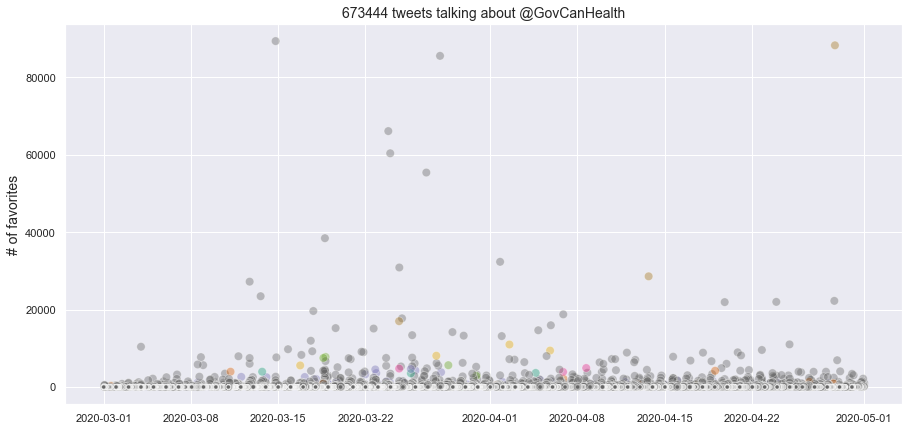

In [265]:
plt.figure(figsize=(15,7))

# sns.set()
# Colours
sns.set_palette("husl")


sns.scatterplot(x='date', y='fav', hue='top_usr', size=df.rt.astype('float'), size_norm=(5,50), data=df, 
                palette='Dark2_r', alpha=.4, legend=False)
plt.ylabel('# of favorites', size=14);
plt.xlabel('')
plt.title('{:.0f} tweets talking about {}'.format(len(df), interesting_text), 
          size=14);

# Tweets per day

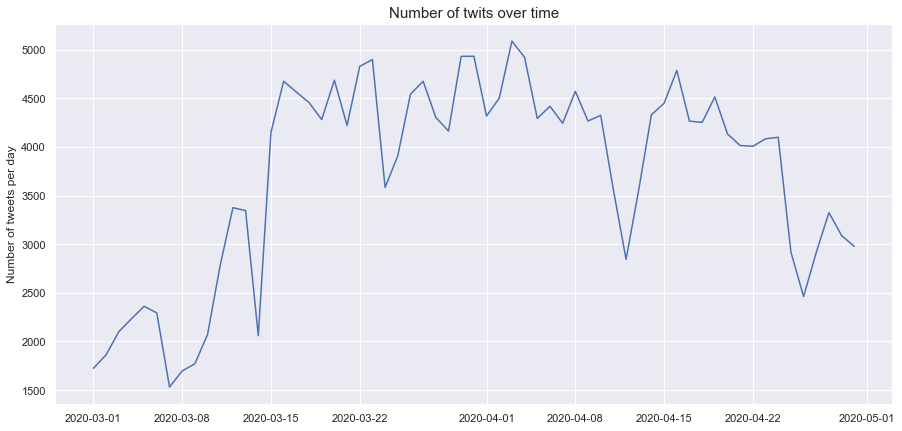

In [331]:
# df.resample('H', on='timestamps').mean()
sns.set()
plt.figure(figsize=(15,7))
plt.title('Number of twits over time', size=15)

# Plotting hist without kde
ax = sns.lineplot(x=df.resample('d', on='date').count().index, y=df[df.text.str.contains('Trudeau')].resample('d', on='date').count().usr);
ax.set_xlabel('');
ax.set_ylabel('Number of tweets per day mentioning Trudeau');

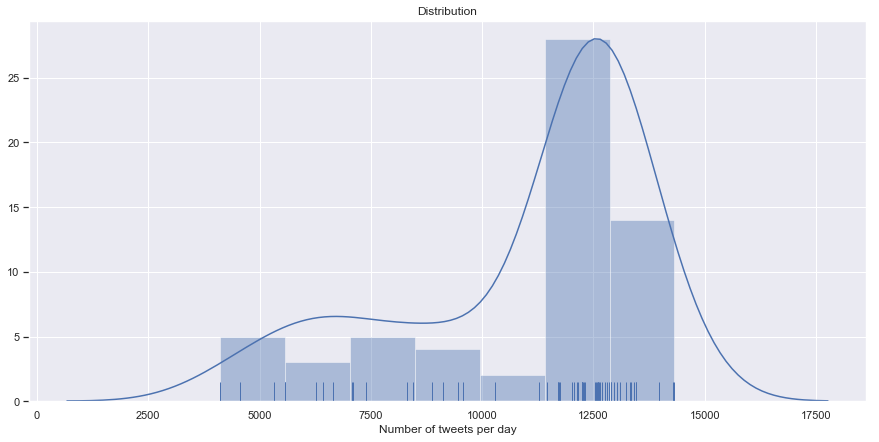

In [267]:
# df.resample('H', on='timestamps').mean()
plt.figure(figsize=(15,7))
plt.title('Distribution')

# Plotting hist without kde
ax = sns.distplot( df.resample('d', on='date').count().usr ,label='Count', kde=False);
# Creating another Y axis
second_ax = ax.twinx()

#Plotting kde without hist on the second Y axis
sns.distplot( df.resample('d', on='date').count().usr , ax=second_ax, rug=True, kde=True, hist=False);
#Removing Y ticks from the second axis
second_ax.set_yticks([]);
ax.set_xlabel('Days distribution');
ax.set_xlabel('Number of tweets per day');

## Most engaging Tweets

In [323]:
# pd.set_option('display.max_colwidth', None)
df[df.fav>50].sort_values(['interactions','rt','fav'], ascending=False).loc[:,['date','usr','rt','fav','text']]

,date,usr,rt,fav,text
ind,,,,,
1243681744294948865,2020-03-27 23:30:08+00:00,JustinTrudeau,24634,85506,"Stay home. It doesn’t matter that the weekend’s almost here - if you choose to gather in groups or hang out with your friends, you’re putting yourself, those around you, and our health care workers at risk. So take this seriously. Do the right thing and stay home this weekend."
1238904264908582914,2020-03-14 19:06:09+00:00,realDonaldTrump,14218,89324,Just had a nice conversation with Prime Minister @JustinTrudeau of Canada. Great to hear that his wonderful wife Sophie is doing very well. The United States and Canada will continue to coordinate closely together on COVID-19.
1255155284588158979,2020-04-28 15:21:54+00:00,narendramodi,9111,88226,Had a warm exchange with PM @JustinTrudeau. Thanked him for looking after Indian citizens in Canada in these difficult times. Collaboration and partnership between India and Canada is vital to fighting the pandemic including through medical research and supply chain management.
1242179031438635010,2020-03-23 19:58:54+00:00,JustinTrudeau,23822,66080,"To the people who seem to think they’re invincible: You’re not. So go home and stay home. You’re not just putting yourself at risk, you’re putting others at risk too - nurses and doctors, grocery store workers, your grandparents, and so many others. #StayAtHomeSaveLives"
1242234576455585793,2020-03-23 23:39:37+00:00,JustinTrudeau,22496,60348,"You need to stay home. And so do your friends and family members. Help spread the word with your own video - and tag your friends to remind them to stay home too. And together, we can #PlankTheCurve. @MichaelBuble and @VancityReynolds - can you help? #StayAtHomeSaveLives"
...,...,...,...,...,...
1253059782300389377,2020-04-22 20:35:07+00:00,JessTherrien17,0,51,"This benefit is drastically lower than CERB, and rightfully should be going to students who need it to help their education and their future. Very closed minded to think the next generation doesn’t deserve a little support."
1253453914533486592,2020-04-23 22:41:15+00:00,SupaleeNate,0,51,Christians have called for the deaths of gay and trans people for decades. Don't act like your religion is any better.
1253452408648278016,2020-04-23 22:35:16+00:00,Balajibril1,0,51,You're hate-filled.


# <span style='color:red'>Export dataframe </span>

In [295]:
%%time
# Save the dfs to disk so that we can make use of it in Tableau 
df.to_csv(path_to_file)

Wall time: 11.1 s


# Sentiment analysis

In [296]:
stopwords = set(STOPWORDS)
stopwords.update(['lo','u',"I'm","We'll", 'Nous', 'di', 'Herr', 'ist','de','die','a','por','https','I', 'noch', 'much', 'uns', 'many', 'day', 'come', 'los', 'eine', 'wie', 'aut', 'les', 'sind','un', 'et','il','le','las','la', 'nos','will', 'dan', 'se', 'au', 'una', 'unas', 'le', 'aut', 'and', 'den', 'ein', 'al', 'des','_','il', 'e', 'en', 'que', 'non', 'da', 'Ich', 'la', 'mit', 'zu', 'es', 'con', 'von', 'und', 'auf', 'auch','sich', 'der', 'hasta', 'das', 'Sie', 'para', 'el', 'per'])

def CleanText(txt):
    txt = re.sub(r'https?:\/\/.*[\r\n]*','',txt) # Remove hyperlinks
    # Remove some nonsense
    txt = re.sub(r'dans le','',txt)
    txt = re.sub(r'Sie uns','',txt)
    txt = re.sub(r'RT[\s]+','',txt) # remove retweets
    txt = re.sub(r'\d+','',txt) #remove digits
#     txt = re.sub(r' https://twitter.com/AFairGoAUS/status/1297320236253769729', '', txt)
    txt = re.sub(' '+' | '.join(stopwords).lstrip(' | ')+' ',' ',txt ) # 🔥 This is the right way to remove stopwords, they're just gone
    
    return txt

## Wordcloud

In [305]:
%%time
allwords = ' '.join(df.text.apply(CleanText).values.tolist())
# allwords
mask = np.array(Image.open('C://Users//cuspi//Documents//Databases//Canada_Twitter//Canadian_Flag.jpg'))

wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA',mask=mask, stopwords=stopwords,
                  font_path='C://WINDOWS//FONTS//LATOWEB-LIGHT.TTF').generate(allwords)

Wall time: 51.1 s


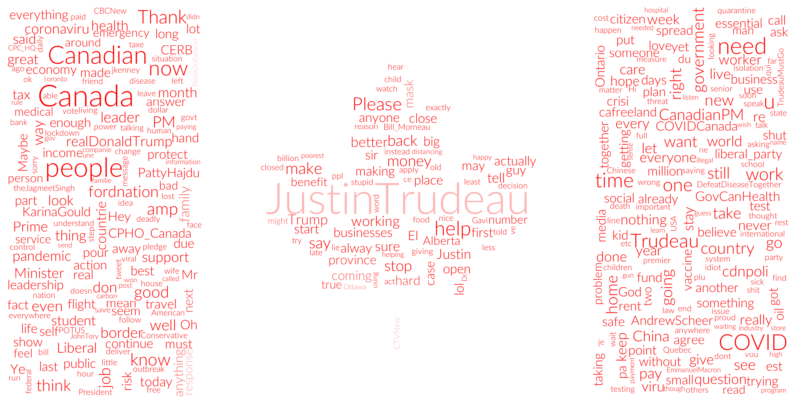

In [306]:
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("C:/Users/cuspi/Documents/Databases/Twitter/lint.jpg", format="jpg")

## To export to Tableau 
We first have to do the same cleaning, remove stopwords like we did and separate by columns so that we can then pivot them in Tableau and count them.

In [309]:
%%time
# Separate the text in columns to make a word counter in Tableau 😎
df['text'].map(CleanText).str.split(expand=True).to_csv('C:\\Users\\cuspi\\Documents\\Databases\\Canada_Twitter\\text_in_columns.csv')

Wall time: 1min 4s


## Subjectivity and Polarity
Let's define a couple of functions that will give us the subjectivity and the polarity of each tweet:

In [ ]:
def GetSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def GetPolarity(txt):
    return TextBlob(txt).sentiment.polaritys

# Create new columns:
df['subjectivity'] = df.text.apply(GetSubjectivity)
df['polarity'] = df.text.apply(GetPolarity)

In [ ]:
df

# Tableau

This project gets much more interesting when one is able to interact with the data. 

In [this Tableau link](https://public.tableau.com/profile/leocuspinera#!/vizhome/Twitter_15978796836980/Dashboard?publish=yes) one can see why:

In [185]:
%%HTML
<iframe src='https://public.tableau.com/views/Twitter_15978796836980/Dashboard?:language=en-GB&:display_count=y&:showVizHome=no&publish=yes&:origin=viz_share_link'  width="100%" height="820 px" style="-webkit-transform:scale(0.8);-moz-transform-scale(0.8);" scrolling="yes" seamless="seamless" frameborder="0" allowfullscreen>

# Working station